# Setup

In [1]:
# import module
import numpy as np
from matplotlib import pyplot as plt
import fsps
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.interpolate import interp1d
from scipy.integrate import simps
from astropy.table import Table



In [2]:
# define working directory

path_figures = '/Users/sandrotacchella/ASTRO/SFH_Variability/variability_SFHs/figures/'


# Define Functions

In [3]:
def exp_decline(t, C, tau):
    return(C*np.exp(-1.0*t/tau))


In [4]:
def integrate_mag(spec_lam, spectra, filter, z=None):
    '''
    borrowed from calc_ml
    given a filter name and spectrum, calculate magnitude/luminosity in filter (see alt_file for filter names)
    INPUT:
        SPEC_LAM: must be in angstroms. this will NOT BE corrected for reddening even if redshift is specified. this
        allows you to calculate magnitudes in rest or observed frame.
        SPECTRA: must be in Lsun/Hz (FSPS standard). if redshift is specified, the normalization will be taken care of.
    OUTPUT:
        MAG: comes out as absolute magnitude
        LUMINOSITY: comes out in erg/s
            NOTE: if redshift is specified, INSTEAD RETURN apparent magnitude and flux [erg/s/cm^2]
    '''
    resp_lam = filter[0][0]
    res = filter[1][0]
    # physical units, in CGS
    pc2cm = 3.08568E18
    lsun = 3.839E33
    c = 2.99E10
    # interpolate filter response onto spectral lambda array
    # when interpolating, set response outside wavelength range to be zero.
    response_interp_function = interp1d(resp_lam, res, bounds_error=False, fill_value=0)
    resp_interp = response_interp_function(spec_lam)
    # integrate spectrum over filter response
    # first calculate luminosity: convert to flambda (factor of c/lam^2, with c converted to AA/s)
    # then integrate over flambda [Lsun/AA] to get Lsun
    spec_flam = spectra*(c*1e8/(spec_lam**2))
    luminosity = simps(spec_flam*resp_interp, spec_lam)
    # now calculate luminosity density [erg/s/Hz] in filter
    # this involves normalizing the filter response by integrating over wavelength
    norm = simps(resp_interp/spec_lam, spec_lam)
    luminosity_density = simps(spectra*(resp_interp/norm)/spec_lam, spec_lam)
    # if redshift is specified, convert to flux and apparent magnitude
    if z is not None:
        dfactor = (cosmo.luminosity_distance(z).value*1e5)**(-2)*(1+z)
        luminosity = luminosity*dfactor
        luminosity_density = luminosity_density*dfactor
    # convert luminosity density to flux density
    # the units of the spectra are Lsun/Hz; convert to
    # erg/s/cm^2/Hz, at 10pc for absolute mags
    flux_density = luminosity_density*lsun/(4.0*np.pi*(pc2cm*10)**2)
    luminosity = luminosity*lsun
    # convert flux density to magnitudes in AB system
    mag = -2.5*np.log10(flux_density)-48.60
    #print 'maggies: {0}'.format(10**(-0.4*mag)*1e10)
    return mag, luminosity


def return_lir(lam, spec, z=None):
    """ returns IR luminosity (8-1000 microns) in erg/s
    input spectrum must be Lsun/Hz, wavelength in \AA
    """
    botlam = np.atleast_1d(8e4-1)
    toplam = np.atleast_1d(1000e4+1)
    edgetrans = np.atleast_1d(0)
    lir_filter = [[np.concatenate((botlam, np.linspace(8e4, 1000e4, num=100), toplam))],
                  [np.concatenate((edgetrans, np.ones(100), edgetrans))]]
    # calculate integral
    _, lir = integrate_mag(lam, spec, lir_filter, z=z)  # comes out in ergs/s
    return lir


def return_luv(lam, spec, z=None):
    """ returns UV luminosity (1216-3000 \AA) in erg/s
    input spectrum must be Lsun/Hz, wavelength in \AA
    """
    botlam = np.atleast_1d(1216)
    toplam = np.atleast_1d(3000)
    edgetrans = np.atleast_1d(0)
    luv_filter = [[np.concatenate((botlam-1, np.linspace(botlam, toplam, num=100), toplam+1))],
                  [np.concatenate((edgetrans, np.ones(100), edgetrans))]]
    # calculate integral
    _, luv = integrate_mag(lam, spec, luv_filter, z=z)  # comes out in ergs/s
    return luv

# SSP 

In [5]:
# set up fsps 
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, imf_type=1, add_neb_emission=True,
                                sfh=0, logzsol=0.0, dust_type=2, dust2=0.5)


In [6]:
# define filters
filters = ['i1500', 'i2800', 'u', 'v', '2mass_j', 'wise_w3']
idx_Halpha = (np.abs(sp.emline_wavelengths-6564.61)).argmin()


In [10]:
# set time bins

time_ssp = np.logspace(-4.0, 1.4, num=500)
time_save = np.linspace(0.0001, 25.0, num=250000)

print time_ssp
print time_save


[1.00000000e-04 1.02523080e-04 1.05109819e-04 1.07761823e-04
 1.10480740e-04 1.13268257e-04 1.16126105e-04 1.19056059e-04
 1.22059938e-04 1.25139608e-04 1.28296980e-04 1.31534015e-04
 1.34852723e-04 1.38255164e-04 1.41743452e-04 1.45319752e-04
 1.48986286e-04 1.52745328e-04 1.56599214e-04 1.60550337e-04
 1.64601150e-04 1.68754168e-04 1.73011970e-04 1.77377200e-04
 1.81852568e-04 1.86440853e-04 1.91144905e-04 1.95967643e-04
 2.00912063e-04 2.05981234e-04 2.11178304e-04 2.16506501e-04
 2.21969133e-04 2.27569591e-04 2.33311353e-04 2.39197984e-04
 2.45233140e-04 2.51420567e-04 2.57764108e-04 2.64267702e-04
 2.70935387e-04 2.77771302e-04 2.84779693e-04 2.91964912e-04
 2.99331419e-04 3.06883789e-04 3.14626712e-04 3.22564994e-04
 3.30703566e-04 3.39047480e-04 3.47601918e-04 3.56372191e-04
 3.65363746e-04 3.74582164e-04 3.84033170e-04 3.93722633e-04
 4.03656569e-04 4.13841145e-04 4.24282687e-04 4.34987677e-04
 4.45962763e-04 4.57214758e-04 4.68750651e-04 4.80577603e-04
 4.92702959e-04 5.051342

In [11]:
# compute luminosities

def get_luminositiies(sp_in, time, tau_dust):
    sp_in.params['dust2'] = tau_dust
    L_mat_ssp = 10**-10*np.ones(8)
    for ii_t in time[1:]:
        mag_list = sp_in.get_mags(tage=ii_t, bands=filters)
        L_list = 4*np.pi*(3.086e+19)**2*np.power(10, -0.4*(mag_list+48.6))
        wave, spec = sp_in.get_spectrum(tage=ii_t)
        LIR = return_lir(wave, spec, z=None)
        L_tot = LIR + 2.2*return_luv(wave, spec, z=None)  # from total UV
        #L_tot2 = LIR + 2.2*1.5*L_list[1]*3e8/(2800*10**-10)  # from 2800
        L_mat_ssp = np.vstack([L_mat_ssp, np.append(np.append(L_list, 3.839*10**33*sp.emline_luminosity[idx_Halpha]), L_tot)])
    L_mat_ssp[0] = L_mat_ssp[1]
    return(L_mat_ssp)


def restructure_lum(time_in, lum_in, time_new):
    #for ii in range(lum_in.shape[1]):
    #    lum_in[:, ii] = lum_in[:, ii]/np.trapz(lum_in[:, ii], 10**3*time_in)
    f = interp1d(time_in, lum_in, axis=0)
    lum_new = f(time_new)
    for ii in range(lum_new.shape[1]):
        lum_new[:, ii] = lum_new[:, ii]/np.sum(lum_new[:, ii])
    return(lum_new)


In [12]:
# get luminosities

L_mat_ssp = get_luminositiies(sp, time_ssp, 0.2)
L_mat_ssp_muchdust = get_luminositiies(sp, time_ssp, 2.0)



In [13]:
# reformat luminosities

L_mat_ssp_final = restructure_lum(time_ssp, L_mat_ssp, time_save)
L_mat_ssp_muchdust_final = restructure_lum(time_ssp, L_mat_ssp_muchdust, time_save)



In [14]:
# save

data = [time_save, L_mat_ssp_final[:, 6], L_mat_ssp_final[:, 0], L_mat_ssp_final[:, 1], L_mat_ssp_final[:, 2], L_mat_ssp_final[:, 5], L_mat_ssp_final[:, 7]]

ascii.write(data, '/Users/sandrotacchella/ASTRO/SFH_Variability/variability_SFHs/scripts/variability_tools/response_function.dat', names=['time', 'Ha', 'FUV', 'NUV', 'u', 'W3', 'UV+IR'], overwrite=True)



In [15]:
# read in data

response_function = Table.read('/Users/sandrotacchella/ASTRO/SFH_Variability/variability_SFHs/scripts/variability_tools/response_function.dat', format='ascii')


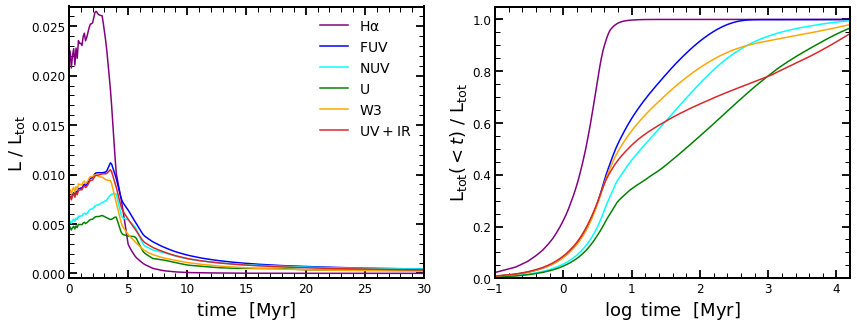

In [21]:
# make figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14.0, 5.))

factor_t = 1000.0
ax1.plot(factor_t*time_save, response_function['Ha'], '-', color='purple', alpha=1.0, label=r'$\mathrm{H\alpha}$')
ax1.plot(factor_t*time_save, response_function['FUV'], '-', color='blue', alpha=1.0, label=r'$\mathrm{FUV}$')
ax1.plot(factor_t*time_save, response_function['NUV'], '-', color='cyan', alpha=1.0, label=r'$\mathrm{NUV}$')
ax1.plot(factor_t*time_save, response_function['u'], '-', color='green', alpha=1.0, label=r'$\mathrm{U}$')
ax1.plot(factor_t*time_save, response_function['W3'], '-', color='orange', alpha=1.0, label=r'$\mathrm{W3}$')
ax1.plot(factor_t*time_save, response_function['UV+IR'], '-', color='C3', alpha=1.0, label=r'$\mathrm{UV+IR}$')

ax1.set_xlim([0.0, 30])
ax1.set_ylim([-0.0005, 0.027])
ax1.set_xlabel(r'$\mathrm{time}\/\/\/\/[\mathrm{Myr}]$', fontsize=18)
ax1.set_ylabel(r'$\mathrm{L\/\//\/\/L_{\rm tot}}$', fontsize=18)
ax1.legend(frameon=False, fontsize=14)

ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['Ha']), '-', color='purple', alpha=1.0, label=r'$\mathrm{H\alpha}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['FUV']), '-', color='blue', alpha=1.0, label=r'$\mathrm{FUV}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['NUV']), '-', color='cyan', alpha=1.0, label=r'$\mathrm{NUV}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['u']), '-', color='green', alpha=1.0, label=r'$\mathrm{U}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['UV+IR']), '-', color='orange', alpha=1.0, label=r'$\mathrm{W3}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(response_function['W3']), '-', color='C3', alpha=1.0, label=r'$\mathrm{UV+IR}$')

'''
ax2.plot(np.log10(factor_t*time_save), np.cumsum(L_mat_ssp_muchdust_final[:, 6]), '--', color='purple', alpha=1.0, label=r'$\mathrm{H\alpha}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(L_mat_ssp_muchdust_final[:, 0]), '--', color='blue', alpha=1.0, label=r'$\mathrm{FUV}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(L_mat_ssp_muchdust_final[:, 1]), '--', color='cyan', alpha=1.0, label=r'$\mathrm{NUV}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(L_mat_ssp_muchdust_final[:, 2]), '--', color='orange', alpha=1.0, label=r'$\mathrm{U}$')
ax2.plot(np.log10(factor_t*time_save), np.cumsum(L_mat_ssp_muchdust_final[:, 7]), '--', color='C3', alpha=1.0, label=r'$\mathrm{UV+IR}$')
'''

ax2.set_xlim([-1.0, 4.2])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel(r'$\log\/\/\/\mathrm{time}\/\/\/\/[\mathrm{Myr}]$', fontsize=18)
ax2.set_ylabel(r'$\mathrm{L_{\rm tot}}(<t)\/\//\/\/\mathrm{L_{\rm tot}}$', fontsize=18)

plt.savefig(path_figures + 'L_evo_ssp.pdf', bbox_inches='tight')
plt.show()
